# Vacuum Wavelength Conversions

This notebook compares various air to vacuum conversion formulas.

* [Greisen *et al.* (2006)](http://adsabs.harvard.edu/abs/2006A%26A...446..747G) cites [International Union of Geodesy and Geophysics (1999)](http://www.iugg.org/assemblies/1999birmingham/1999crendus.pdf)
  - This version is used by [specutils](https://github.com/astropy/specutils).
  - Specifically, this is based on the *phase* refractivity of air, there is a slightly different formula for the *group* refractivity of air.
* [Ciddor (1996)](http://adsabs.harvard.edu/abs/1996ApOpt..35.1566C)
  - Used by [PyDL](https://github.com/weaverba137/pydl) via the [Goddard IDL library](https://asd.gsfc.nasa.gov/archive/idlastro/).
  - This is the standard used by SDSS, at least since 2011.  Prior to 2011, the Goddard IDL library used the IAU formula (below) plus an approximation of its inverse for vacuum to air.
* [The wcslib *code*](https://github.com/astropy/astropy/blob/master/cextern/wcslib/C/spx.c) uses the formula from Cox, *Allen’s Astrophysical Quantities* (2000), itself derived from [Edlén (1953)](http://adsabs.harvard.edu/abs/1953JOSA...43..339E), even though Greisen *et al.* (2006) says, "The standard relation given by Cox (2000) is mathematically intractable and somewhat dated."
  - Interestingly, this is the **IAU** standard, adopted in 1957 and again in 1991.  No more recent IAU resolution replaces this formula.

This would be a bit of a deep dive, but it would be interesting to see if these functions are based on measurements of the refractive index of air, *or* on explicit comparison of measured wavelengths in air to measured wavelengths in vacuum.

As shown below, the Greisen formula gives consistently larger values when converting air to vacuum.  The Ciddor and wcslib values are almost, but not quite, indistinguishable.  The wcslib formula has a singularity at a value less than 2000 Å.  The Ciddor formula probably has a similar singularity, but it explicitly hides this by not converting values less than 2000 Å.

```
int waveawav(dummy, nwave, swave, sawav, wave, awav, stat)

double dummy;
int nwave, swave, sawav;
const double wave[];
double awav[];
int stat[];

{
  int status = 0;
  double n, s;
  register int iwave, k, *statp;
  register const double *wavep;
  register double *awavp;

  wavep = wave;
  awavp = awav;
  statp = stat;
  for (iwave = 0; iwave < nwave; iwave++) {
    if (*wavep != 0.0) {
      n = 1.0;
      for (k = 0; k < 4; k++) {
        s  = n/(*wavep);
        s *= s;
        n  =   2.554e8 / (0.41e14 - s);
        n += 294.981e8 / (1.46e14 - s);
        n += 1.000064328;
      }

      *awavp = (*wavep)/n;
      *(statp++) = 0;
    } else {
      *(statp++) = 1;
      status = SPXERR_BAD_INSPEC_COORD;
    }

    wavep += swave;
    awavp += sawav;
  }

  return status;
}

int awavwave(dummy, nawav, sawav, swave, awav, wave, stat)

double dummy;
int nawav, sawav, swave;
const double awav[];
double wave[];
int stat[];

{
  int status = 0;
  double n, s;
  register int iawav, *statp;
  register const double *awavp;
  register double *wavep;

  awavp = awav;
  wavep = wave;
  statp = stat;
  for (iawav = 0; iawav < nawav; iawav++) {
    if (*awavp != 0.0) {
      s = 1.0/(*awavp);
      s *= s;
      n  =   2.554e8 / (0.41e14 - s);
      n += 294.981e8 / (1.46e14 - s);
      n += 1.000064328;
      *wavep = (*awavp)*n;
      *(statp++) = 0;
    } else {
      *(statp++) = 1;
      status = SPXERR_BAD_INSPEC_COORD;
    }

    awavp += sawav;
    wavep += swave;
  }

  return status;
}
```

In [13]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
import astropy.units as u
from pydl.goddard.astro import airtovac, vactoair
wavelength = np.logspace(3,5,200) * u.Angstrom

In [2]:
def waveawav(wavelength):
    """Vacuum to air conversion as actually implemented by wcslib.
    """
    wave = wavelength.to(u.m).value
    n = 1.0
    for k in range(4):
        s = (n/wave)**2
        n = 2.554e8 / (0.41e14 - s)
        n += 294.981e8 / (1.46e14 - s)
        n += 1.000064328
    return wavelength / n

def awavwave(wavelength):
    """Air to vacuum conversion as actually implemented by wcslib.

    Have to convert to meters(!) for this formula to work.
    """
    awav = wavelength.to(u.m).value
    s = (1.0/awav)**2
    n = 2.554e8 / (0.41e14 - s)
    n += 294.981e8 / (1.46e14 - s)
    n += 1.000064328
    return wavelength * n

In [3]:
#
# These functions aren't defined until specutils 0.3.x.  However specviz needs 0.2.2.
#
def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength

def vac_to_air(wavelength):
    """
    Griesen 2006 reports that the error in naively inverting Eqn 65 is less
    than 10^-9 and therefore acceptable.  This is therefore eqn 67
    """
    wlum = wavelength.to(u.um).value
    nl = (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4))
    return wavelength/nl

In [14]:
greisen_a2v = air_to_vac(wavelength) / wavelength - 1.0
ciddor_a2v = airtovac(wavelength) / wavelength - 1.0
wcslib_a2v = awavwave(wavelength) / wavelength - 1.0
good = (greisen_a2v > 0) & (ciddor_a2v > 0) & (wcslib_a2v > 0)

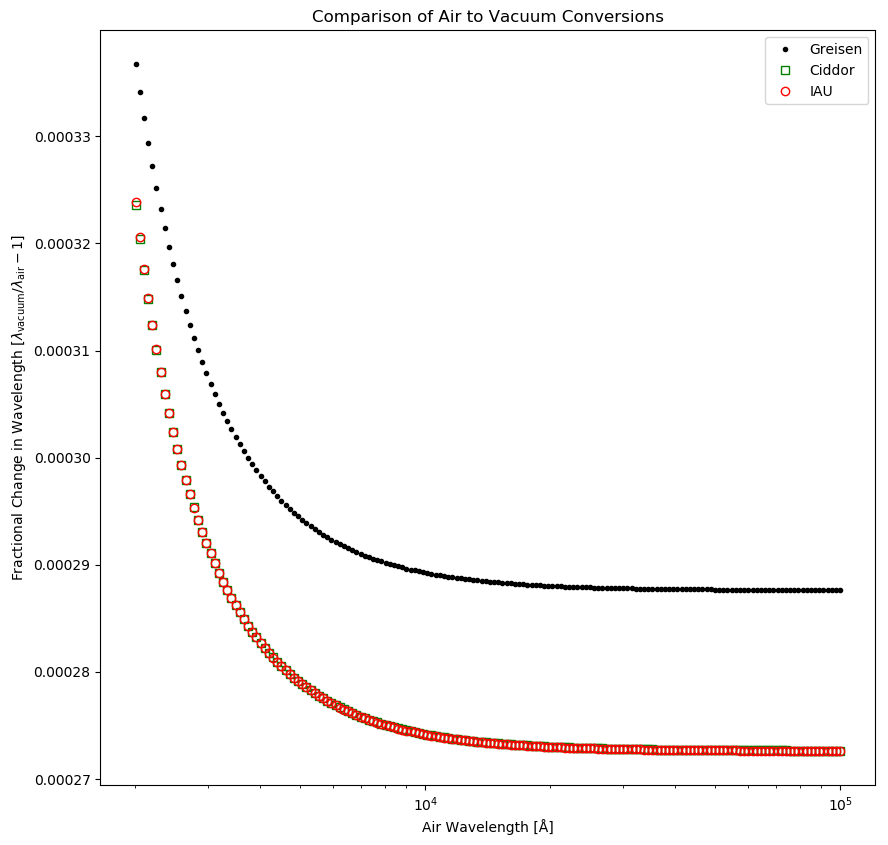

In [16]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)
p1 = ax.semilogx(wavelength[good], greisen_a2v[good], 'k.', label='Greisen')
p2 = ax.semilogx(wavelength[good], ciddor_a2v[good], 'gs', label='Ciddor')
p3 = ax.semilogx(wavelength[good], wcslib_a2v[good], 'ro', label='IAU')
foo = p2[0].set_markeredgecolor('g')
foo = p2[0].set_markerfacecolor('none')
foo = p3[0].set_markeredgecolor('r')
foo = p3[0].set_markerfacecolor('none')
# foo = ax.set_xlim([-5, 10])
# foo = ax.set_ylim([24, 15])
foo = ax.set_xlabel('Air Wavelength [Å]')
foo = ax.set_ylabel('Fractional Change in Wavelength [$\\lambda_{\\mathrm{vacuum}}/\\lambda_{\mathrm{air}} - 1$]')
foo = ax.set_title('Comparison of Air to Vacuum Conversions')
l = ax.legend(numpoints=1)

In [19]:
greisen_v2a = 1.0 - vac_to_air(wavelength) / wavelength
ciddor_v2a = 1.0 - vactoair(wavelength) / wavelength
wcslib_v2a = 1.0 - waveawav(wavelength) / wavelength
good = (greisen_v2a > 0) & (ciddor_v2a > 0) & (wcslib_v2a > 0)

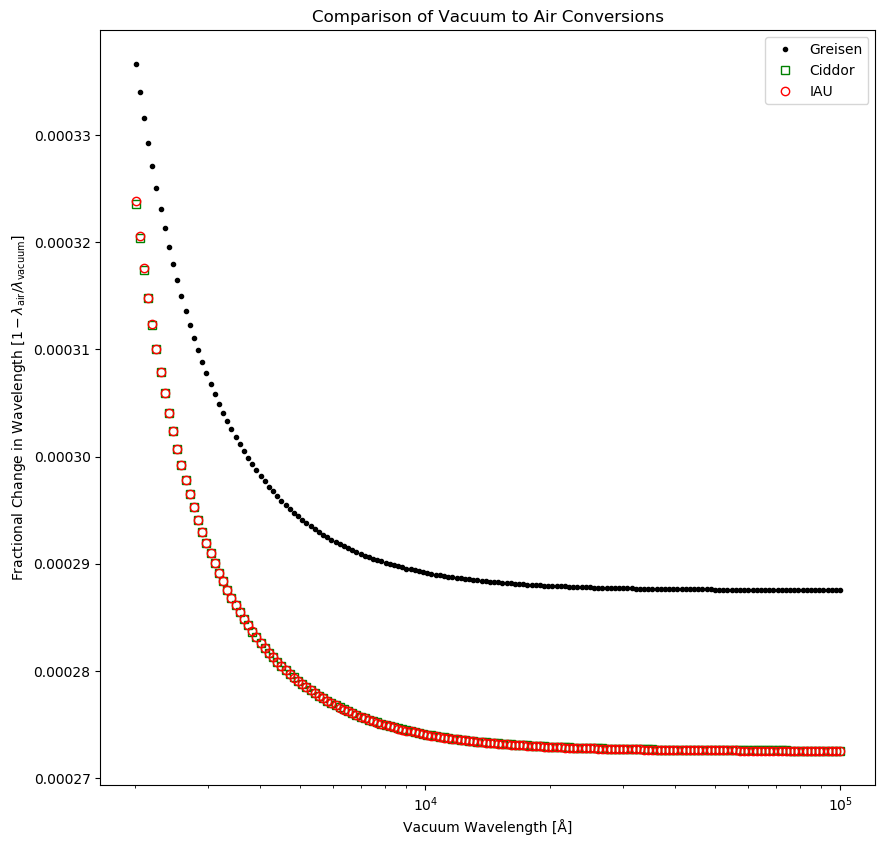

In [20]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)
p1 = ax.semilogx(wavelength[good], greisen_v2a[good], 'k.', label='Greisen')
p2 = ax.semilogx(wavelength[good], ciddor_v2a[good], 'gs', label='Ciddor')
p3 = ax.semilogx(wavelength[good], wcslib_v2a[good], 'ro', label='IAU')
foo = p2[0].set_markeredgecolor('g')
foo = p2[0].set_markerfacecolor('none')
foo = p3[0].set_markeredgecolor('r')
foo = p3[0].set_markerfacecolor('none')
# foo = ax.set_xlim([-5, 10])
# foo = ax.set_ylim([24, 15])
foo = ax.set_xlabel('Vacuum Wavelength [Å]')
foo = ax.set_ylabel('Fractional Change in Wavelength [$1 - \\lambda_{\\mathrm{air}}/\\lambda_{\mathrm{vacuum}}$]')
foo = ax.set_title('Comparison of Vacuum to Air Conversions')
l = ax.legend(numpoints=1)